# Demonstration of how to pipelines between X22 model and RADMC-3D

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('..')
from radmc.setup import radmc3d_setup
from radmc.simulate import generate_simulation
from radmc.plot import generate_plot
import os 

from radmc3dPy import image
from radmc3dPy.analyze import *

## Generate disk model and RADMC3D-required files

In [16]:
amax        = 1 # maximum grain size in mm
mstar       = 0.5 # stellar mass in solar masses
mdot        = 5e-5 # accretion rate in solar masses per year
rd          = 50 # disk radius in AU
Toomre_Q    = 0.4 # Toomre Q parameter
l_star      = .1 # stellar luminosity in solar luminosities
heating     = 'accretion' # heating mechanism

In [17]:
model = radmc3d_setup(silent=False)
model.get_mastercontrol(filename=None,
                        comment=None,
                        incl_dust=1,
                        incl_lines=1,
                        nphot=500000,
                        nphot_scat=5000000,
                        scattering_mode_max=2,
                        istar_sphere=1,
                        num_cpu=None,
                        modified_random_walk = 1
                        )
model.get_linecontrol(filename=None,
                    methanol='ch3oh leiden 0 0 0')
model.get_continuumlambda(filename=None,
                        comment=None,
                        lambda_micron=None,
                        append=False)

model.get_diskcontrol(  d_to_g_ratio    = 0.01,
                        a_max           = amax, # mm
                        Mass_of_star    = mstar, # Msun
                        Accretion_rate  = mdot, # Msun/yr
                        Radius_of_disk  = rd,   # AU
                        Q               = Toomre_Q, # Toomre Q
                        NR    =200,
                        NTheta=200,
                        NPhi  =20,
                        )
model.get_vfieldcontrol(Kep=True,
                        vinfall=0.5, # the infall velocity (unit: Keperian velocity)
                        Rcb=None, # the centrifugal barrier
                        outflow=None)
model.get_heatcontrol(L_star=l_star, # Lsun
                      R_star=1,
                      heat=heating) # radiation/accretion
model.get_gasdensitycontrol(abundance=1e-10, # abundance of CH3OH compared to H2
                            snowline=100, # snowline temperature
                            enhancement=1e5, # enhancement factor of abundance inside snowline
                            gas_inside_rcb=True)

You have 24 Processors
get_continuumlambda: No input wavelength.
get_continuumlambda: Re-creating wavelength_micron.inp using default wavelengths.


## RADMC3D simulations

In [18]:
simulation = generate_simulation(save_out=True, save_npz=True)

simulate_mutual_parms = {
    "incl"      : 50,
    "line"      : 240,
    "npix"      : 500,
    "sizeau"    : 150,
    "v_width"   : 10,
    "vkms"      : 0,
    "v_width"   : 10,
    "posang"    : 100,
    "dir"       : './test/',
    "fname"     : 'test',
}


In [19]:
# simulation.generate_cube(
#     nodust=False, scat=True, extract_gas=True,
#     nlam=11,
#     **simulate_mutual_parms
# )

In [20]:
# simulation.generate_cube(
#     nodust=False, scat=True, extract_gas=True,
#     nlam=50,
#     **simulate_mutual_parms
# )

In [21]:
simulation.generate_continuum(
   scat=True,
   wav=3000,
   **simulate_mutual_parms
)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

In [22]:
# simulation.generate_sed(
#     scat=True,
#     freq_min=5e1, freq_max=5e2, nlam=10,
#     **simulate_mutual_parms
# )


In [23]:
# simulation.generate_line_spectrum(
#     nodust=False, scat=True, extract_gas=True,
#     nlam=10,
#     **simulate_mutual_parms
# )

## Plot

### Continuum image

In [24]:
distance = 140 # distance in pc

sizeau = simulate_mutual_parms['sizeau']
npix = simulate_mutual_parms['npix']
pixel_area = (sizeau/npix/140)**2

beam_axis = [0.0478, 0.0441] # beam axis in arcsec
beam_area = beam_axis[0]*beam_axis[1]*np.pi/(4*np.log(2))

f_dir  = simulate_mutual_parms['dir']
f_name = simulate_mutual_parms['fname']

In [25]:
model_img = image.readImage(fname=f'./{f_dir}/outfile/conti_{f_name}_scat.out')
conv_image = model_img.imConv(dpc=distance, fwhm=beam_axis, pa=-79.32)
conv_image.imageJyppix *= beam_area/pixel_area/(distance**2)

Reading ././test//outfile/conti_test_scat.out


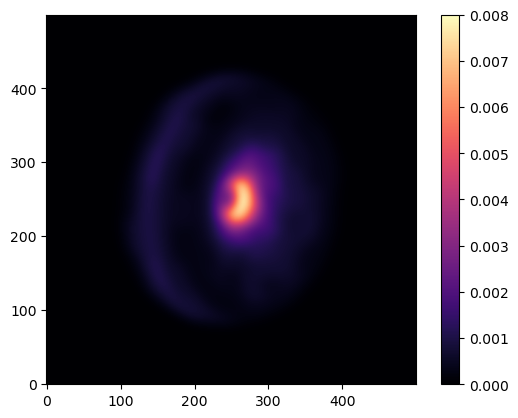

In [26]:
plt.imshow(conv_image.imageJyppix[:, :, 0].T, origin='lower', cmap="magma", vmin=0, vmax=0.008)
plt.colorbar()